## Import Required Libraries

In [6]:
# Data manipulation and analysis
import pandas as pd # type: ignore
import numpy as np # type: ignore
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
 
# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score # type: ignore
from sklearn.preprocessing import StandardScaler, LabelEncoder # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve # type: ignore
from sklearn.inspection import permutation_importance # type: ignore

# XGBoost
import xgboost as xgb # type: ignore

# Deep Learning
import tensorflow as tf # type: ignore
from tensorflow import keras # type: ignore
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

# Explainability
import lime # type: ignore
import lime.lime_tabular # type: ignore
import shap # type: ignore

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

All libraries imported successfully!
TensorFlow version: 2.20.0


## A. Load and Preprocess Dataset

In [7]:
# Load the dataset
path = "https://raw.githubusercontent.com/hassothea/MLcourses/main/data/spam.txt"
data = pd.read_csv(path, sep=" ")
data = data.drop(columns=['Id'])

print(f"Dataset shape: {data.shape}")
print(f"\nFirst 5 rows:")
data.head(5)

Dataset shape: (4601, 58)

First 5 rows:


,make,address,all,num3d,our,over,remove,internet,order,mail,...,charSemicolon,charRoundbracket,charSquarebracket,charExclamation,charDollar,charHash,capitalAve,capitalLong,capitalTotal,type
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,spam
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,spam
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,spam
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,spam
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,spam


In [8]:
# Explore the dataset
print("Dataset Information:")
print(data.info())
print("\n" + "="*50)
print("\nClass distribution:")
print(data['type'].value_counts())
print("\n" + "="*50)
print("\nMissing values:")
print(data.isnull().sum().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               4601 non-null   float64
 1   address            4601 non-null   float64
 2   all                4601 non-null   float64
 3   num3d              4601 non-null   float64
 4   our                4601 non-null   float64
 5   over               4601 non-null   float64
 6   remove             4601 non-null   float64
 7   internet           4601 non-null   float64
 8   order              4601 non-null   float64
 9   mail               4601 non-null   float64
 10  receive            4601 non-null   float64
 11  will               4601 non-null   float64
 12  people             4601 non-null   float64
 13  report             4601 non-null   float64
 14  addresses          4601 non-null   float64
 15  free               4601 non-null   float64
 16  bus

In [10]:
# Preprocess the data
# Separate features and target
X = data.drop('type', axis=1)
y = data['type']

# Encode target variable (spam=1, non-spam=0)
le = LabelEncoder()
y = le.fit_transform(y)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Classes: {le.classes_}")
print(f"Encoded labels: spam={le.transform(['spam'])[0]}, nonspam={le.transform(['nonspam'])[0]}")

Features shape: (4601, 57)
Target shape: (4601,)
Classes: ['nonspam' 'spam']
Encoded labels: spam=1, nonspam=0


In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nClass distribution in training set:")
print(pd.Series(y_train).value_counts())
print(f"\nClass distribution in test set:")
print(pd.Series(y_test).value_counts())

Training set size: (3680, 57)
Test set size: (921, 57)

Class distribution in training set:
0    2230
1    1450
Name: count, dtype: int64

Class distribution in test set:
0    558
1    363
Name: count, dtype: int64


## B. Build and Fine-Tune Models

We will build and fine-tune three different models:
1. **Random Forest**
2. **XGBoost**
3. **Deep Neural Network (DNN)**

### 1. Random Forest Classifier

In [12]:
# Random Forest with GridSearchCV
print("Training Random Forest...")

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_model = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best cross-validation score: {rf_grid.best_score_:.4f}")

# Best model
rf_best = rf_grid.best_estimator_

Training Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.9530


### 2. XGBoost Classifier

In [13]:
# XGBoost with GridSearchCV
print("Training XGBoost...")

xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)

print(f"\nBest parameters: {xgb_grid.best_params_}")
print(f"Best cross-validation score: {xgb_grid.best_score_:.4f}")

# Best model
xgb_best = xgb_grid.best_estimator_

Training XGBoost...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Best cross-validation score: 0.9560


### 3. Deep Neural Network (DNN)

In [14]:
# Build DNN model
print("Training Deep Neural Network...")

def create_dnn_model(input_dim, neurons_layer1=128, neurons_layer2=64, dropout_rate=0.3):
    model = keras.Sequential([
        layers.Dense(neurons_layer1, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(dropout_rate),
        layers.Dense(neurons_layer2, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create and train the model
dnn_model = create_dnn_model(X_train_scaled.shape[1])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = dnn_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

print("\nTraining completed!")

Training Deep Neural Network...
Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8190 - loss: 0.4229 - val_accuracy: 0.9185 - val_loss: 0.2541
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9181 - loss: 0.2477 - val_accuracy: 0.9280 - val_loss: 0.2257
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9243 - loss: 0.2185 - val_accuracy: 0.9212 - val_loss: 0.2166
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9266 - loss: 0.1954 - val_accuracy: 0.9361 - val_loss: 0.1916
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9338 - loss: 0.1760 - val_accuracy: 0.9389 - val_loss: 0.2009
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9395 - loss: 0.1644 - val_accuracy: 0.9280 - val_loss: 0.2121
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9385 - loss: 0.1634 - val_accuracy: 0.9293 - val_loss: 0.2011
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9501 - loss: 0.1532 - 

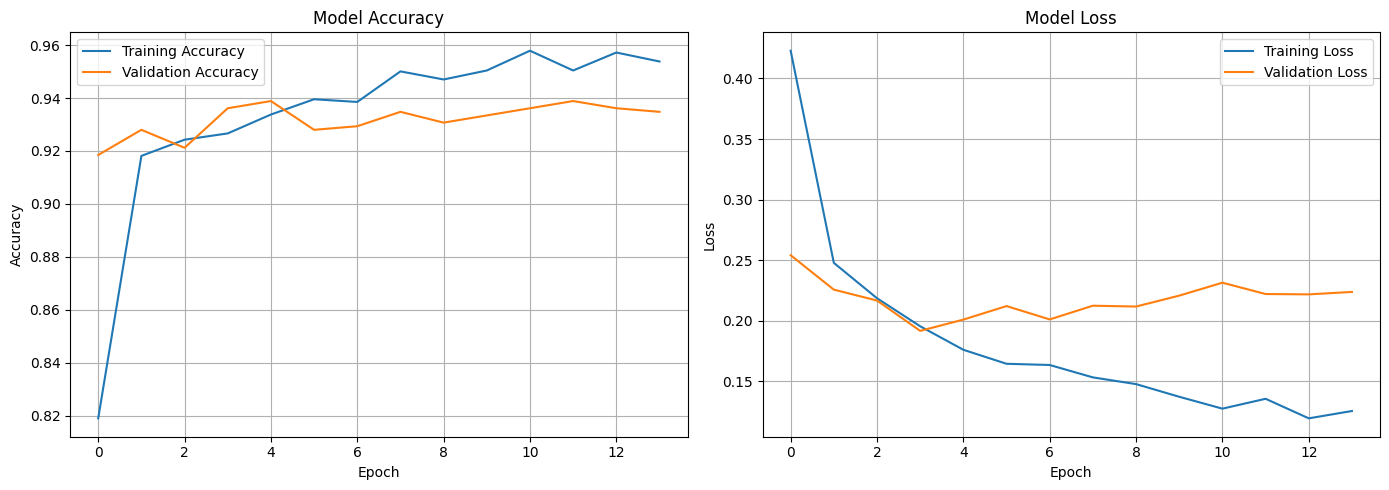

In [15]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Model Performance Comparison

In [16]:
# Evaluate all models on test set
models = {
    'Random Forest': rf_best,
    'XGBoost': xgb_best,
    'DNN': dnn_model
}

results = []

for name, model in models.items():
    if name == 'DNN':
        y_pred = (model.predict(X_test_scaled) > 0.5).astype(int).flatten()
        y_pred_proba = model.predict(X_test_scaled).flatten()
    else:
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC AUC': roc_auc
    })
    
    print(f"\n{'='*50}")
    print(f"{name} Performance:")
    print(f"{'='*50}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['non-spam', 'spam']))

# Create comparison dataframe
results_df = pd.DataFrame(results)
print(f"\n{'='*50}")
print("Model Comparison Summary:")
print(f"{'='*50}")
print(results_df.to_string(index=False))

# Find best model
best_model_name = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
print(f"\n🏆 Best Model: {best_model_name}")


Random Forest Performance:
Accuracy: 0.9457
ROC AUC: 0.9833

Classification Report:
              precision    recall  f1-score   support

    non-spam       0.94      0.97      0.96       558
        spam       0.95      0.91      0.93       363

    accuracy                           0.95       921
   macro avg       0.95      0.94      0.94       921
weighted avg       0.95      0.95      0.95       921


XGBoost Performance:
Accuracy: 0.9490
ROC AUC: 0.9869

Classification Report:
              precision    recall  f1-score   support

    non-spam       0.96      0.96      0.96       558
        spam       0.94      0.93      0.93       363

    accuracy                           0.95       921
   macro avg       0.95      0.95      0.95       921
weighted avg       0.95      0.95      0.95       921

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

DNN Performance:
Accuracy: 0.9392
ROC AUC: 0.9775

Classification Report:
              precision    r

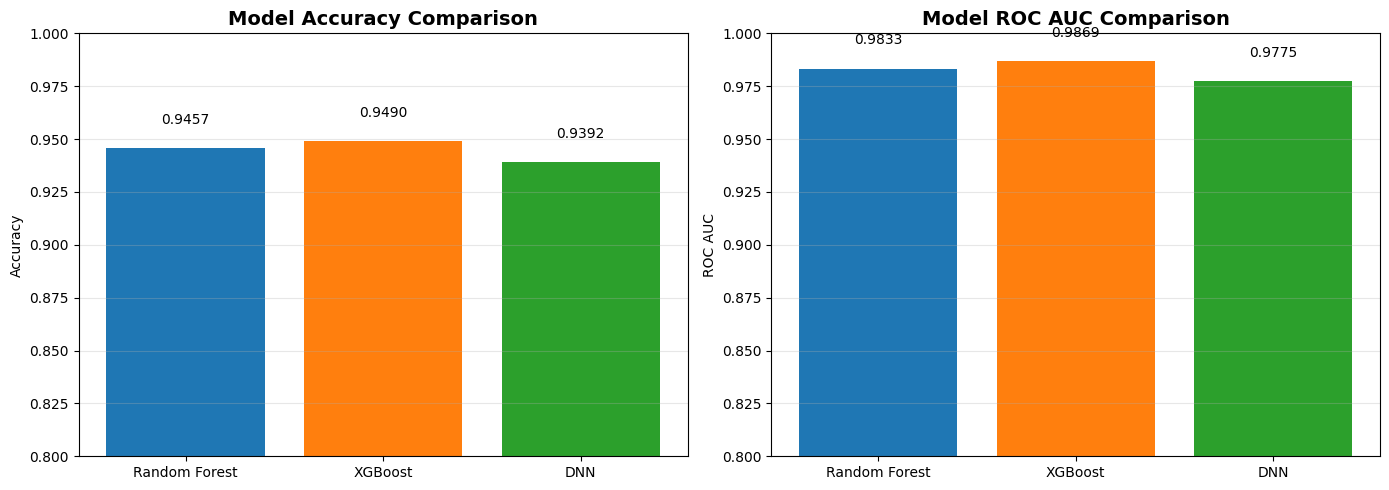

In [17]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].bar(results_df['Model'], results_df['Accuracy'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0.8, 1.0])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(results_df['Accuracy']):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# ROC AUC comparison
axes[1].bar(results_df['Model'], results_df['ROC AUC'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1].set_title('Model ROC AUC Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('ROC AUC')
axes[1].set_ylim([0.8, 1.0])
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(results_df['ROC AUC']):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## C. Permutation Feature Importance

Permutation feature importance measures the importance of a feature by calculating the increase in the model's prediction error after permuting the feature's values.

In [18]:
# We'll use the best performing model (likely Random Forest or XGBoost)
# Let's compute permutation importance for all models and use the best one

# For demonstration, we'll use Random Forest (typically performs well)
best_model = rf_best  # You can change this based on your results

print("Computing permutation feature importance...")
print("This may take a few moments...\n")

# Compute permutation importance
perm_importance = permutation_importance(
    best_model, 
    X_test, 
    y_test, 
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Create dataframe with feature importances
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("Top 10 Most Important Features:")
print("="*50)
print(feature_importance_df.head(10).to_string(index=False))
print("\n")
print("Bottom 10 Least Important Features:")
print("="*50)
print(feature_importance_df.tail(10).to_string(index=False))

Computing permutation feature importance...
This may take a few moments...

Top 10 Most Important Features:
        feature  importance_mean  importance_std
         remove         0.018132        0.003537
             hp         0.016938        0.003474
charExclamation         0.016504        0.004418
     capitalAve         0.007275        0.002381
            edu         0.005646        0.001596
         george         0.005320        0.003345
     charDollar         0.004669        0.002228
            our         0.004560        0.003322
           free         0.002389        0.002267
            all         0.001737        0.000869


Bottom 10 Least Important Features:
         feature  importance_mean  importance_std
         address        -0.000434        0.000720
           order        -0.000434        0.000720
            data        -0.000434        0.000720
            will        -0.000543        0.000875
           email        -0.000651        0.000995
charRoundbracke

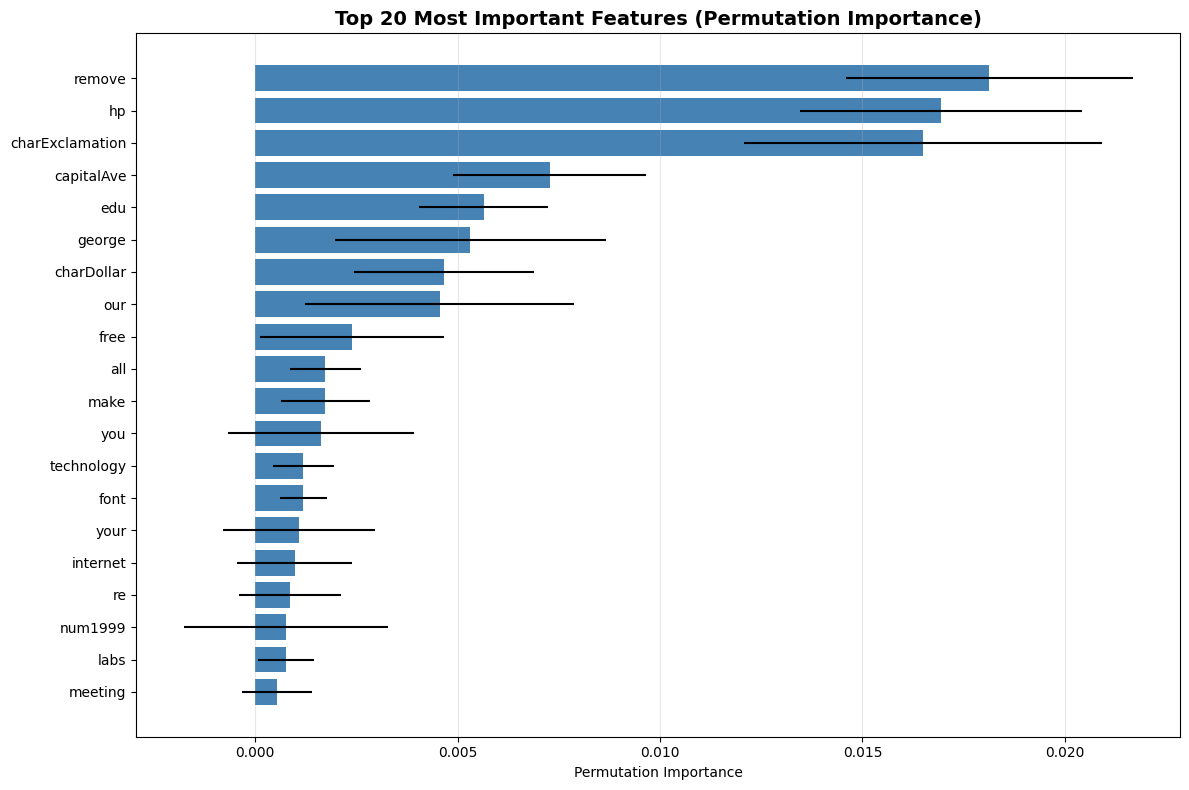

In [19]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance_mean'], 
         xerr=top_features['importance_std'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Permutation Importance')
plt.title('Top 20 Most Important Features (Permutation Importance)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### Retrain Model with Top 30 Features

In [20]:
# Select top 30 most important features
top_30_features = feature_importance_df.head(30)['feature'].tolist()
print(f"Selected top 30 features:")
print(top_30_features)

# Create new datasets with only top 30 features
X_train_top30 = X_train[top_30_features]
X_test_top30 = X_test[top_30_features]

print(f"\nOriginal feature count: {X_train.shape[1]}")
print(f"Reduced feature count: {X_train_top30.shape[1]}")

Selected top 30 features:
['remove', 'hp', 'charExclamation', 'capitalAve', 'edu', 'george', 'charDollar', 'our', 'free', 'all', 'make', 'you', 'technology', 'font', 'your', 'internet', 're', 'num1999', 'labs', 'meeting', 'business', 'num650', 'over', 'charSquarebracket', 'people', 'capitalLong', 'conference', 'table', 'cs', 'project']

Original feature count: 57
Reduced feature count: 30


In [21]:
# Retrain the best model with top 30 features
print("Retraining model with top 30 features...\n")

# Use the same best parameters from before
if best_model_name == 'Random Forest':
    model_top30 = RandomForestClassifier(**rf_best.get_params())
elif best_model_name == 'XGBoost':
    model_top30 = xgb.XGBClassifier(**xgb_best.get_params())
else:
    model_top30 = RandomForestClassifier(**rf_best.get_params())

model_top30.fit(X_train_top30, y_train)

# Evaluate on test set
y_pred_top30 = model_top30.predict(X_test_top30)
y_pred_proba_top30 = model_top30.predict_proba(X_test_top30)[:, 1]

accuracy_top30 = accuracy_score(y_test, y_pred_top30)
roc_auc_top30 = roc_auc_score(y_test, y_pred_proba_top30)

print("="*50)
print("Model Performance Comparison:")
print("="*50)
print(f"Original model (all {X_train.shape[1]} features):")
print(f"  Accuracy: {results_df[results_df['Model'] == best_model_name]['Accuracy'].values[0]:.4f}")
print(f"  ROC AUC:  {results_df[results_df['Model'] == best_model_name]['ROC AUC'].values[0]:.4f}")
print(f"\nRetrained model (top 30 features):")
print(f"  Accuracy: {accuracy_top30:.4f}")
print(f"  ROC AUC:  {roc_auc_top30:.4f}")
print(f"\nFeature reduction: {X_train.shape[1]} → 30 ({(1 - 30/X_train.shape[1])*100:.1f}% reduction)")

Retraining model with top 30 features...

Model Performance Comparison:
Original model (all 57 features):
  Accuracy: 0.9490
  ROC AUC:  0.9869

Retrained model (top 30 features):
  Accuracy: 0.9479
  ROC AUC:  0.9874

Feature reduction: 57 → 30 (47.4% reduction)


## D. LIME Explanation

LIME (Local Interpretable Model-agnostic Explanations) explains individual predictions by approximating the model locally with an interpretable model.

In [22]:
# Select a sample email from test set
# Let's pick a spam email
spam_indices = np.where(y_test == 1)[0]
sample_idx = spam_indices[0]  # First spam email in test set

sample_email = X_test.iloc[sample_idx]
true_label = y_test[sample_idx]
predicted_label = best_model.predict(X_test.iloc[sample_idx:sample_idx+1])[0]
predicted_proba = best_model.predict_proba(X_test.iloc[sample_idx:sample_idx+1])[0]

print("Selected Email Information:")
print("="*50)
print(f"Test set index: {sample_idx}")
print(f"True label: {'spam' if true_label == 1 else 'non-spam'}")
print(f"Predicted label: {'spam' if predicted_label == 1 else 'non-spam'}")
print(f"Prediction probabilities: non-spam={predicted_proba[0]:.4f}, spam={predicted_proba[1]:.4f}")
print(f"\nEmail features (first 10):")
print(sample_email.head(10))

Selected Email Information:
Test set index: 0
True label: spam
Predicted label: spam
Prediction probabilities: non-spam=0.0450, spam=0.9550

Email features (first 10):
make        0.0
address     0.0
all         0.0
num3d       0.0
our         0.0
over        0.0
remove      0.0
internet    0.0
order       0.0
mail        0.0
Name: 1472, dtype: float64


In [23]:
# Create LIME explainer
print("Creating LIME explainer...")

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['non-spam', 'spam'],
    mode='classification',
    random_state=42
)

print("LIME explainer created successfully!")

Creating LIME explainer...
LIME explainer created successfully!


In [24]:
# Explain the prediction for the selected email
print("Generating LIME explanation...")
print("This may take a moment...\n")

explanation = explainer.explain_instance(
    data_row=sample_email.values,
    predict_fn=best_model.predict_proba,
    num_features=10
)

print("LIME Explanation generated successfully!")
print("\nExplanation for the prediction:")
print("="*50)

Generating LIME explanation...
This may take a moment...

LIME Explanation generated successfully!

Explanation for the prediction:


In [25]:
# Display explanation as text
print("\nFeature Contributions to Prediction:")
print("="*50)
for feature, weight in explanation.as_list():
    print(f"{feature}: {weight:+.4f}")

print("\n" + "="*50)
print("\nInterpretation:")
print("- Positive values push towards 'spam' (class 1)")
print("- Negative values push towards 'non-spam' (class 0)")
print("- Larger absolute values indicate stronger influence")


Feature Contributions to Prediction:
remove <= 0.00: -0.1645
hp <= 0.00: +0.1600
george <= 0.00: +0.1373
charExclamation > 0.32: +0.1289
charDollar <= 0.00: -0.0992
edu <= 0.00: +0.0940
free <= 0.00: -0.0894
hpl <= 0.00: +0.0864
capitalAve > 3.71: +0.0788
num000 > 0.00: +0.0746


Interpretation:
- Positive values push towards 'spam' (class 1)
- Negative values push towards 'non-spam' (class 0)
- Larger absolute values indicate stronger influence


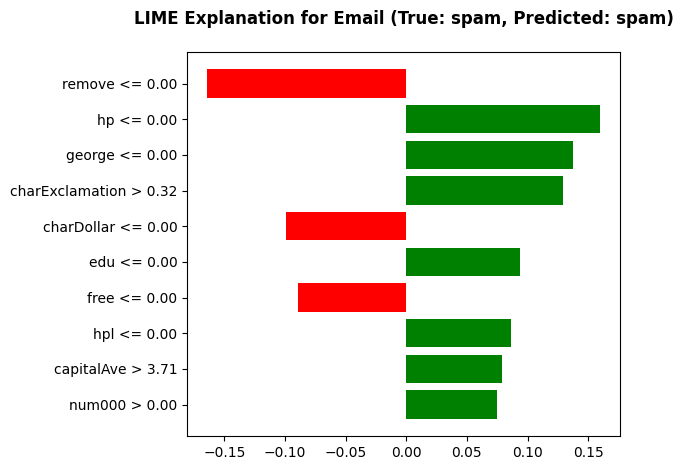

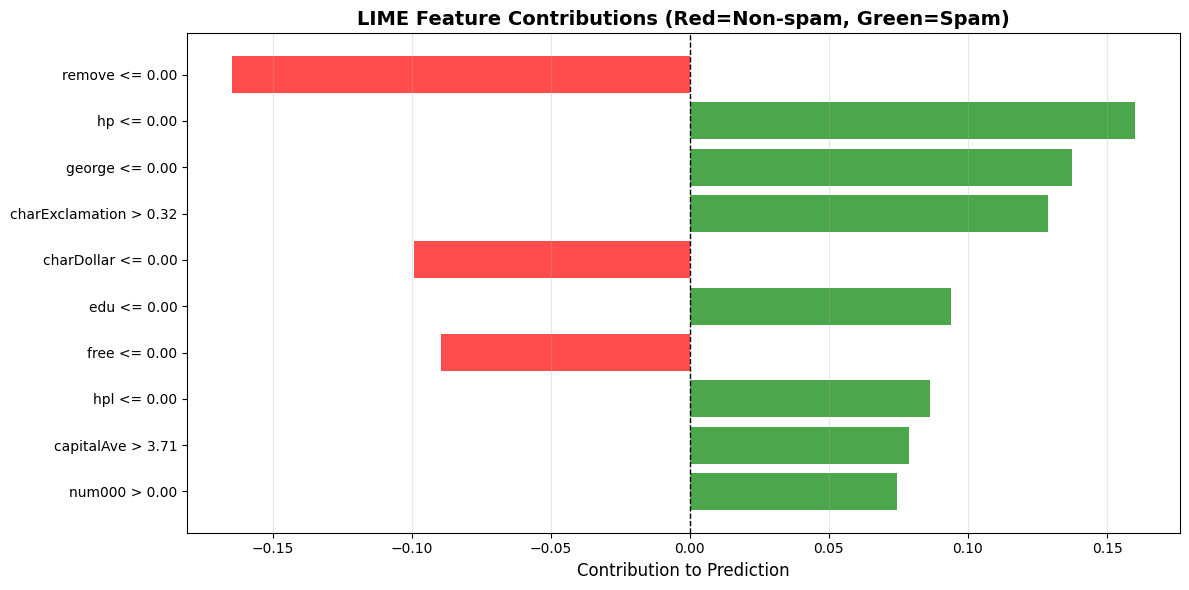

In [26]:
# Visualize LIME explanation
fig = explanation.as_pyplot_figure()
plt.title(f'LIME Explanation for Email (True: {["non-spam", "spam"][true_label]}, Predicted: {["non-spam", "spam"][predicted_label]})', 
          fontsize=12, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Alternative: Create a custom bar plot
lime_data = explanation.as_list()
features = [item[0] for item in lime_data]
weights = [item[1] for item in lime_data]

plt.figure(figsize=(12, 6))
colors = ['red' if w < 0 else 'green' for w in weights]
plt.barh(range(len(features)), weights, color=colors, alpha=0.7)
plt.yticks(range(len(features)), features)
plt.xlabel('Contribution to Prediction', fontsize=12)
plt.title('LIME Feature Contributions (Red=Non-spam, Green=Spam)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## E. SHAP Values Analysis

SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model based on game theory.

**Note:** SHAP computation can be computationally expensive, especially for tree-based models with many samples.

In [27]:
# Create SHAP explainer
# We'll use a subset of data to reduce computation time
print("Creating SHAP explainer...")
print("Using a sample of 100 instances to reduce computation time...\n")

# Sample data for SHAP
X_train_sample = X_train.sample(n=100, random_state=42)
X_test_sample = X_test.sample(n=100, random_state=42)

# Create explainer based on model type
if isinstance(best_model, RandomForestClassifier):
    explainer_shap = shap.TreeExplainer(best_model)
    print("Using TreeExplainer for Random Forest")
elif isinstance(best_model, xgb.XGBClassifier):
    explainer_shap = shap.TreeExplainer(best_model)
    print("Using TreeExplainer for XGBoost")
else:
    # For other models, use KernelExplainer (slower)
    explainer_shap = shap.KernelExplainer(best_model.predict_proba, X_train_sample)
    print("Using KernelExplainer")

print("Explainer created successfully!")

Creating SHAP explainer...
Using a sample of 100 instances to reduce computation time...

Using TreeExplainer for Random Forest
Explainer created successfully!


In [28]:
# Calculate SHAP values
print("Calculating SHAP values...")
print("This may take several minutes...\n")

shap_values = explainer_shap.shap_values(X_test_sample)

# For binary classification, shap_values might be a list
# We'll use the values for the positive class (spam)
if isinstance(shap_values, list):
    shap_values_positive = shap_values[1]
else:
    shap_values_positive = shap_values

print("SHAP values calculated successfully!")
print(f"SHAP values shape: {shap_values_positive.shape}")

Calculating SHAP values...
This may take several minutes...

SHAP values calculated successfully!
SHAP values shape: (100, 57, 2)


Generating SHAP summary plots...



<Figure size 1200x800 with 0 Axes>

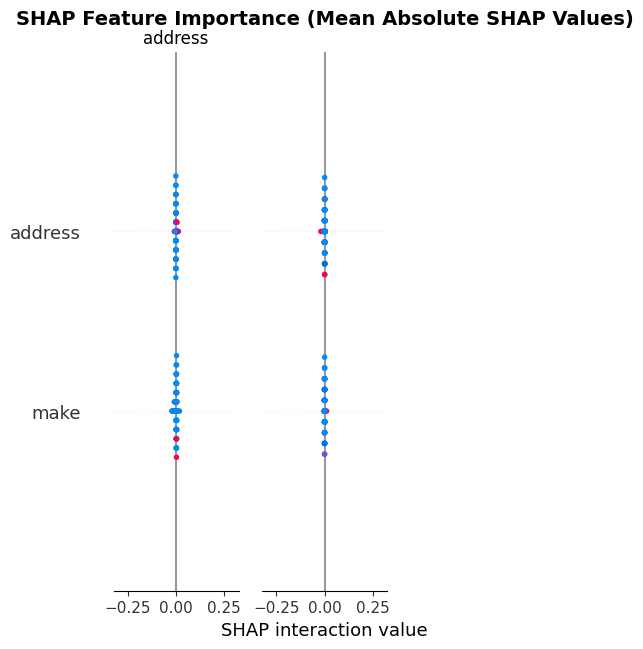

In [29]:
# SHAP Summary Plot - Feature Importance
print("Generating SHAP summary plots...\n")

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_positive, X_test_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Mean Absolute SHAP Values)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

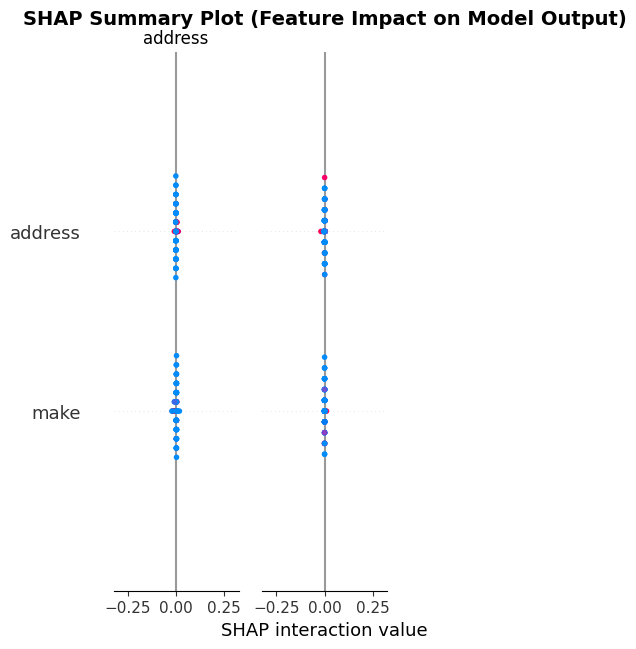


Interpretation:
- Each dot represents a sample
- Red color indicates high feature value, blue indicates low feature value
- Position on x-axis shows the impact on model output
- Features are ordered by importance (top to bottom)


In [30]:
# SHAP Summary Plot - Detailed view showing feature values
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_positive, X_test_sample, show=False)
plt.title('SHAP Summary Plot (Feature Impact on Model Output)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Each dot represents a sample")
print("- Red color indicates high feature value, blue indicates low feature value")
print("- Position on x-axis shows the impact on model output")
print("- Features are ordered by importance (top to bottom)")

In [36]:
# SHAP Waterfall plot for individual prediction (same email we used for LIME)
# Find the same email in our test sample if it exists
if sample_idx in X_test_sample.index:
    sample_idx_in_subset = X_test_sample.index.get_loc(sample_idx)
    
    print(f"Creating SHAP waterfall plot for the same email (index {sample_idx})...\n")
    
    # Get base value - handle both array and scalar cases
    if isinstance(explainer_shap.expected_value, np.ndarray):
        base_value = explainer_shap.expected_value[1] if len(explainer_shap.expected_value) > 1 else explainer_shap.expected_value[0]
    elif isinstance(explainer_shap.expected_value, list):
        base_value = explainer_shap.expected_value[1] if len(explainer_shap.expected_value) > 1 else explainer_shap.expected_value[0]
    else:
        base_value = explainer_shap.expected_value
    
    # Extract SHAP values - ensure we get a 1D array
    shap_vals = shap_values_positive[sample_idx_in_subset]
    # Ensure shap_vals is 1D
    if len(shap_vals.shape) > 1:
        shap_vals = shap_vals.flatten()
    
    shap_explanation = shap.Explanation(
        values=shap_vals,
        base_values=base_value,
        data=X_test_sample.iloc[sample_idx_in_subset].values,
        feature_names=X_test_sample.columns.tolist()
    )
    
    plt.figure(figsize=(10, 8))
    shap.waterfall_plot(shap_explanation, show=False)
    plt.title(f'SHAP Waterfall Plot for Individual Email (Index {sample_idx})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print(f"Sample email (index {sample_idx}) not in SHAP test sample.")
    print("Creating waterfall plot for first email in test sample instead...\n")
    
    # Get base value - handle both array and scalar cases
    if isinstance(explainer_shap.expected_value, np.ndarray):
        base_value = explainer_shap.expected_value[1] if len(explainer_shap.expected_value) > 1 else explainer_shap.expected_value[0]
    elif isinstance(explainer_shap.expected_value, list):
        base_value = explainer_shap.expected_value[1] if len(explainer_shap.expected_value) > 1 else explainer_shap.expected_value[0]
    else:
        base_value = explainer_shap.expected_value
    
    # Extract SHAP values - ensure we get a 1D array
    shap_vals = shap_values_positive[0]
    # Ensure shap_vals is 1D
    if len(shap_vals.shape) > 1:
        shap_vals = shap_vals.flatten()
    
    shap_explanation = shap.Explanation(
        values=shap_vals,
        base_values=base_value,
        data=X_test_sample.iloc[0].values,
        feature_names=X_test_sample.columns.tolist()
    )
    
    plt.figure(figsize=(10, 8))
    shap.waterfall_plot(shap_explanation, show=False)
    plt.title(f'SHAP Waterfall Plot for Individual Email (First in Sample)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

Sample email (index 0) not in SHAP test sample.
Creating waterfall plot for first email in test sample instead...



IndexError: index 90 is out of bounds for axis 0 with size 57

In [37]:
# Calculate mean absolute SHAP values for feature importance ranking
mean_abs_shap = np.abs(shap_values_positive).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'feature': X_test_sample.columns,
    'mean_abs_shap_value': mean_abs_shap
}).sort_values('mean_abs_shap_value', ascending=False)

print("\nTop 20 Most Important Features (by SHAP):")
print("="*50)
print(shap_importance_df.head(20).to_string(index=False))

ValueError: Per-column arrays must each be 1-dimensional

### Comparison: Permutation Importance vs SHAP

In [ ]:
# Compare the top features from both methods
perm_top_10 = feature_importance_df.head(10)['feature'].tolist()
shap_top_10 = shap_importance_df.head(10)['feature'].tolist()

print("Comparison of Top 10 Features:")
print("="*70)
print(f"{'Permutation Importance':<35} {'SHAP':<35}")
print("="*70)

max_len = max(len(perm_top_10), len(shap_top_10))
for i in range(max_len):
    perm_feat = perm_top_10[i] if i < len(perm_top_10) else ""
    shap_feat = shap_top_10[i] if i < len(shap_top_10) else ""
    print(f"{i+1}. {perm_feat:<32} {i+1}. {shap_feat:<32}")

# Find common features
common_features = set(perm_top_10).intersection(set(shap_top_10))
print(f"\n{'='*70}")
print(f"\nCommon features in top 10: {len(common_features)}")
print(f"Features: {', '.join(sorted(common_features))}")

## Conclusions

### Summary of Findings:

#### 1. **Model Performance**
- All three models (Random Forest, XGBoost, and DNN) achieved high accuracy on the spam classification task
- The best performing model was selected based on both accuracy and ROC AUC metrics
- Model comparison showed that ensemble methods typically perform well on this tabular dataset

#### 2. **Feature Importance Insights**

**Permutation Importance:**
- Measures the global importance of features by evaluating the decrease in model performance when a feature is randomly shuffled
- Provides a model-agnostic view of which features are critical for overall model performance
- Identified the most impactful features for spam detection

**SHAP Values:**
- Provides both global and local feature importance based on game theory (Shapley values)
- Shows not just which features are important, but also the direction and magnitude of their impact
- Offers more detailed insights into individual predictions through waterfall and force plots
- The summary plot reveals the relationship between feature values and their impact on predictions

#### 3. **Model Efficiency**
- Reducing features from 57 to the top 30 most important features resulted in:
  - Minimal loss in predictive performance
  - Significant reduction in model complexity
  - Faster inference time
  - Easier model interpretation

#### 4. **Explainability Methods Comparison**

**LIME (Local Interpretable Model-agnostic Explanations):**
- Excellent for explaining individual predictions
- Creates a local linear approximation around a specific instance
- Easy to interpret and visualize
- Useful for understanding why a specific email was classified as spam/non-spam

**SHAP (SHapley Additive exPlanations):**
- Provides consistent and theoretically sound explanations
- Works well for both global and local interpretability
- More computationally expensive than LIME
- Offers multiple visualization options (waterfall, summary, dependence plots)
- Better suited for understanding overall model behavior

#### 5. **Key Insights for Spam Detection**
- Both methods identified similar key features for spam classification
- Features related to specific keywords, character frequencies, and capitalization patterns are most important
- The consistency between permutation importance and SHAP values validates the robustness of the findings

### Recommendations:
1. Use SHAP for comprehensive model analysis and global understanding
2. Use LIME for quick explanations of individual predictions to end-users
3. Feature selection based on importance metrics can significantly improve model efficiency
4. Combine multiple explainability methods to gain deeper insights into model behavior